#### Vivendo case 
##### Vivendo is a fast food chain in Brazil with over 200 outlets.Customers often claim compensation from the company for food poisoning. The legal team processes these claims. The legal team has offices in four locations. The legal team wants to improve how long it takes to reply to customers and close claims.The head of the legal department wants a report on how each location differs in the time it takes to close claims.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc


df=pd.read_csv("food_claims_2212.csv")
df.head()


,claim_id,time_to_close,claim_amount,amount_paid,location,individuals_on_claim,linked_cases,cause
0,1,317,R$ 74474.55,51231.37,RECIFE,15,False,unknown
1,2,195,R$ 52137.83,42111.30,FORTALEZA,12,True,unknown
2,3,183,R$ 24447.2,23986.30,SAO LUIS,10,True,meat
3,4,186,R$ 29006.28,27942.72,FORTALEZA,11,False,meat
4,5,138,R$ 19520.6,16251.06,RECIFE,11,False,vegetable


In [8]:
df.shape

(2000, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   claim_id              2000 non-null   int64  
 1   time_to_close         2000 non-null   int64  
 2   claim_amount          2000 non-null   object 
 3   amount_paid           1964 non-null   float64
 4   location              2000 non-null   object 
 5   individuals_on_claim  2000 non-null   int64  
 6   linked_cases          1974 non-null   object 
 7   cause                 2000 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 125.1+ KB


In [10]:
## Missing values - amount_paid (change missing values to median) ,linked_cases (change missing values to false)
## changing dtypes - time_to close in days ,claim_amount (object to float)and dropping currency symbol,
## checking unique for claim_id .removing duplicates
## checking for outliers in claim_amount,amount_paid.



In [11]:
data_df=df.copy()
data_df[data_df['amount_paid'].isnull()]['amount_paid']=data_df['amount_paid'].median



C:\Users\rutur\AppData\Local\Temp\ipykernel_23244\4284823204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[data_df['amount_paid'].isnull()]['amount_paid']=data_df['amount_paid'].median


In [12]:
data_df=data_df[~data_df['linked_cases'].isna()]


In [13]:
data_df['claim_amount']=data_df['claim_amount'].astype("str")
#data_df[data_df['claim_amount'].isna()]
data_df['claim_amount']=data_df['claim_amount'].str.replace("R$", "")

In [14]:
data_df['claim_amount']=data_df['claim_amount'].astype(float)
data_df.drop_duplicates('claim_id',inplace=True)


In [15]:
data_df['cause'].unique()
## issue with capital vegetable and meat

data_df['cause']=data_df['cause'].str.strip().str.lower()
data_df['cause']=data_df['cause'].apply( lambda x:"vegetable" if x=="vegetables" else x )

data_df['cause'].unique()

array(['unknown', 'meat', 'vegetable'], dtype=object)

<Axes: xlabel='location'>

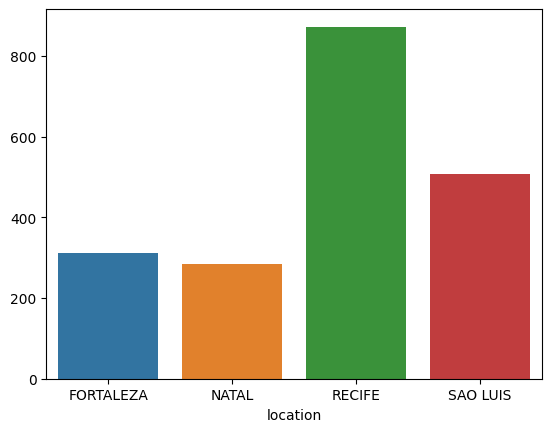

In [16]:

sns.barplot(data=data_df,x=data_df.groupby('location')['claim_id'].count().index,y=data_df.groupby('location')['claim_id'].count().values)

<Axes: xlabel='time_to_close', ylabel='Count'>

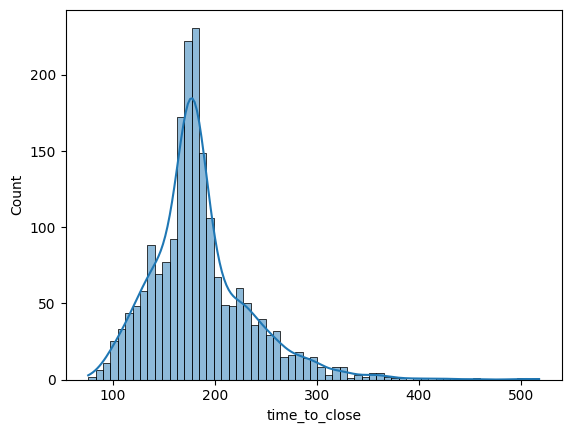

In [19]:
sns.histplot(data=data_df,x='time_to_close',kde=True)

#### to check which type of distribution it follows


In [51]:
def replace_outliers_with_mean(arr, threshold=3):
    """
    Replace outliers in a NumPy array with the mean of the non-outliers.

    Parameters:
        arr (numpy.ndarray): The input NumPy array.
        threshold (float): The number of standard deviations away from the mean to consider as an outlier.

    Returns:
        numpy.ndarray: A new array with outliers replaced by the mean of non-outliers.
    """
    # Calculate the mean and standard deviation of the array
    arr_mean = np.mean(arr)
    arr_std = np.std(arr)

    # Define the lower and upper bounds for outliers
    lower_bound = arr_mean - threshold * arr_std
    upper_bound = arr_mean + threshold * arr_std

    # Create a copy of the input array to avoid modifying the original
    arr_copy = np.copy(arr)

    # Replace outliers with the mean
    arr_copy[(arr < lower_bound) | (arr > upper_bound)] = arr_mean

    return arr_copy

0       317
1       195
2       183
3       186
4       138
       ... 
1969    176
1970    166
1971    179
1972    162
1973    150
Length: 1974, dtype: int64


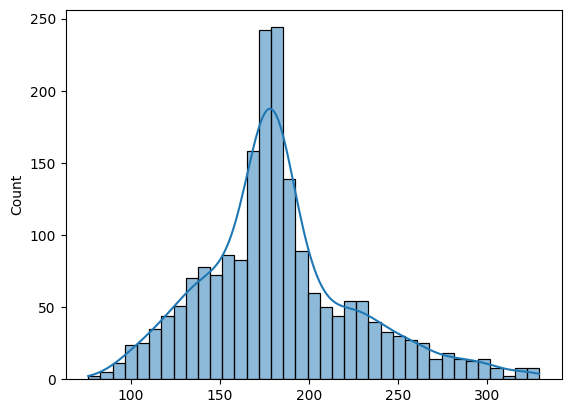

In [65]:
import scipy.stats as stats
results=[]
data=np.array(data_df['time_to_close'])
data_without_outlier=replace_outliers_with_mean(data)
print(pd.Series(data_without_outlier))

sns.histplot(data=data_without_outlier,kde=True)        
distributions=[ 'norm', 'expon', 'uniform', 'gamma', 'logistic', 'weibull_min']
### perform goodness of fit
for distribution_name in distributions:
    distribution = getattr(stats, distribution_name)
    parameters = distribution.fit(data)
    ks_statistic, ks_p_value = stats.kstest(data_without_outlier, distribution_name, args=parameters)
    results.append((distribution_name, ks_statistic, ks_p_value))

In [55]:
results.sort(key=lambda x: x[1])  # Sort by KS statistic (lower is better)

for distribution_name, ks_statistic, ks_p_value in results:
    print(f"Distribution: {distribution_name}, KS Statistic: {ks_statistic}, p-value: {ks_p_value}")

Distribution: logistic, KS Statistic: 0.09272489681365759, p-value: 3.2030112310360837e-15
Distribution: gamma, KS Statistic: 0.09445045348651426, p-value: 8.895367796924537e-16
Distribution: weibull_min, KS Statistic: 0.11622166719221583, p-value: 1.0964690061650302e-23
Distribution: norm, KS Statistic: 0.14189650706940038, p-value: 3.843797158972735e-35
Distribution: expon, KS Statistic: 0.29854564126085004, p-value: 1.6939952316021216e-156
Distribution: uniform, KS Statistic: 0.5247401743021267, p-value: 0.0


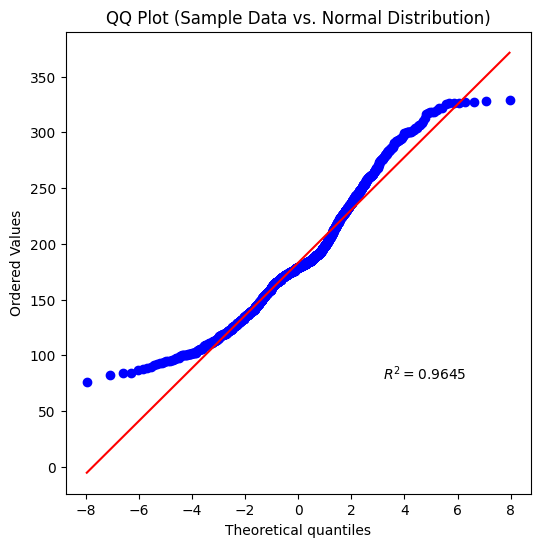

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(data_without_outlier, dist='logistic', sparams=(0.0,1.0),plot=ax, fit=True, rvalue=True)
ax.set_title("QQ Plot (Sample Data vs. Normal Distribution)")

plt.show()

<Axes: xlabel='location', ylabel='time_to_close'>

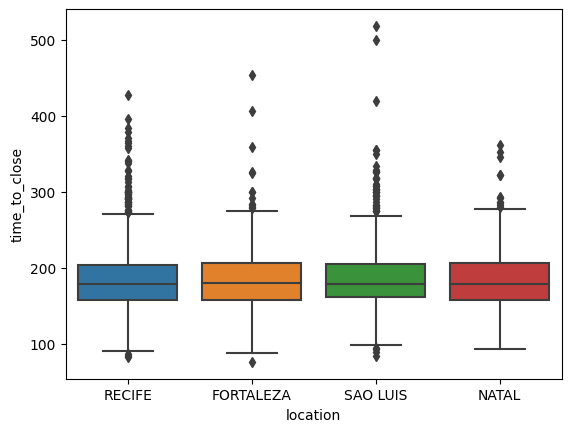

In [ ]:
sns.boxplot(x=data_df['location'],y=data_df['time_to_close'])